# Imports

%%capture
! pip install seaborn

In [1]:
%%time
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader, Dataset

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, GPUStatsMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch as th
import torch.nn.functional as F
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from PIL import Image
# data module
from src.dataset import DataModule

# model
from src.model import Model

# config file
from src.config import Config

CPU times: user 2.7 s, sys: 894 ms, total: 3.6 s
Wall time: 11.4 s


# EDA part

In [2]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'train.csv'))
ss_df = pd.read_csv(os.path.join(Config.data_dir, 'sample_submission.csv'))

In [3]:
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
ss_df.head()

,image_id,label
0,2216849948.jpg,4


In [5]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,21397.0,2.651914,0.988565,0.0,2.0,3.0,3.0,4.0


In [6]:
train_df.label.unique()

array([0, 3, 1, 2, 4])

In [7]:
n_classes = train_df.label.nunique()
n_classes

5

In [11]:
classes = {"0": "Cassava Bacterial Blight (CBB)",
 "1": "Cassava Brown Streak Disease (CBSD)",
 "2": "Cassava Green Mottle (CGM)",
 "3": "Cassava Mosaic Disease (CMD)",
 "4": "Healthy"}


classes.values()

dict_values(['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy'])

In [12]:
classes['4']

'Healthy'

In [70]:
train_df['Class'] = train_df['label'].apply(lambda t: classes[str(t)])
train_df.head()

,image_id,label,class,Class
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB),Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD),Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD),Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD),Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD),Cassava Mosaic Disease (CMD)


# Class distribution

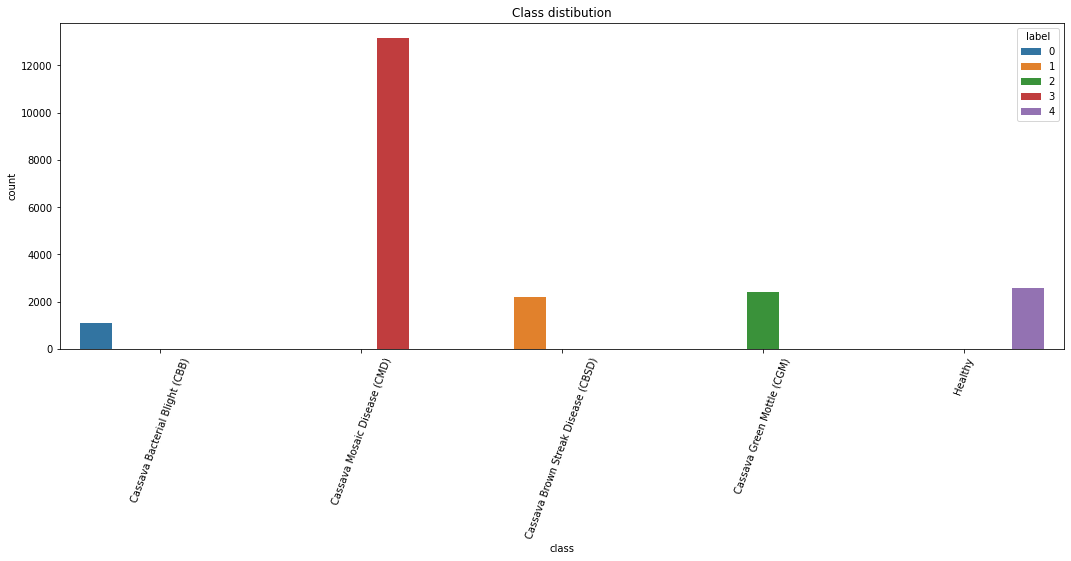

In [14]:
plt.figure(figsize=(18, 6))
sns.countplot(data=train_df, x='class', hue='label')
plt.title('Class distibution')
plt.xticks(rotation=70)
plt.show()

In [38]:
train_df.label.value_counts() / len(train_df) * 100

3    61.494602
4    12.043744
2    11.151096
1    10.230406
0     5.080151
Name: label, dtype: float64

# See an example of training image

In [43]:
def get_tensor_from_image(img):
    """
        get a PIL image and transform it to a torch tensor
        input : 
            - (img) : PIL image
        returns :
            - normalized torch tensor (C, H, W) where :
                C : number of channels
                H : image height
                W : image width
                
                
        >>> img = Image.open(<image path>))
        >>> img_t = get_tensor_from_image(img=img)
        >>> print(img_t.shape)
        # output example
        # torch.Size([3, 600, 800])

    """
    img_t = th.from_numpy(np.array(img).transpose(2, 0, 1)).float() / 255.
    
    return img_t


def swap_shape(array, to_image=True):
    if torch.Size([3, 600, 800]):
        try:
            swapped_array = array.numpy()
            swapped_array = swapped_array.transpose(1, 2, 0)
        except:
              swapped_array = array.transpose(1, 2, 0)
    else:
        print('[INFO] The provided array is not an image-like array or tensor ')
    return swapped_array

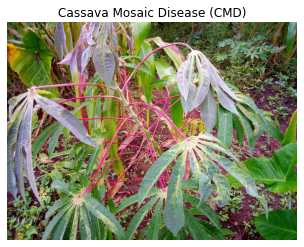

In [91]:
n = np.random.randint(low=0, high=len(train_df))
img_id = train_df.iloc[n].image_id
img_label = train_df.iloc[n].Class

img = Image.open(os.path.join(Config.train_data_dir, img_id))
img_t = get_tensor_from_image(img=img)
swap_img = swap_shape(array=img_t)
plt.imshow(np.clip(swap_img, 0, 1))
plt.title(img_label)
plt.axis('off')
plt.show()